In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import math, os, glob
import seaborn as sns
import sys
from datetime import datetime, timedelta
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', 500)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import statsmodels
import pickle
%matplotlib inline

from sklearn.linear_model import Ridge, LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [2]:
from sklearn.ensemble import RandomForestClassifier

In [3]:
claims = pd.read_csv('C:/Users/Nguyen/Documents/Python Scripts/claims_byYear2.csv')
members = pd.read_csv('C:/Users/Nguyen/Documents/Python Scripts/new_members2.csv')
drugs = pd.read_csv('C:/Users/Nguyen/Documents/Python Scripts/new_drugcount.csv')
labs = pd.read_csv('C:/Users/Nguyen/Documents/Python Scripts/new_labcount.csv')
DY2 = pd.read_csv('C:/Users/Nguyen/AIA/PD exercises/DaysInHospital_Y2.csv')
DY3 = pd.read_csv('C:/Users/Nguyen/AIA/PD exercises/DaysInHospital_Y3.csv')

In [4]:
drugs_labs = pd.DataFrame()
drugs_labs = pd.merge(drugs,labs, on = ['MemberID','Year'], how = 'outer')
drugs_labs.head()

,MemberID,Year,Drug_total,Drug_count,DSFS_drugcount,DSFS_drugmax,DSFS_drugmin,Lab_total,Lab_count,DSFS_labcount,DSFS_labmax,DSFS_labmin
0,210,Y1,5.000,3.000,3.000,5.000,1.000,2.000,1.000,1.000,2.000,2.000
1,210,Y3,5.000,4.000,4.000,9.000,6.000,1.000,1.000,1.000,3.000,3.000
2,3197,Y1,5.000,4.000,4.000,12.000,2.000,nan,nan,nan,nan,nan
3,3197,Y2,3.000,2.000,2.000,2.000,1.000,2.000,1.000,1.000,2.000,2.000
4,3197,Y3,6.000,5.000,5.000,12.000,0.000,nan,nan,nan,nan,nan


In [5]:
drugs_labs.drop(['Drug_count','Lab_count','DSFS_drugmax','DSFS_drugmin','DSFS_labmax','DSFS_labmin'], axis='columns', inplace=True)

In [6]:
drugs_labs.shape

(186802, 6)

In [7]:
#Kiểm tra tính null của các cột trong bảng drugs_labs
total_drugslabs = drugs_labs.isnull().sum().sort_values(ascending=False)
percent_drugslabs = (drugs_labs.isnull().sum()/drugs_labs.isnull().count()).sort_values(ascending=False)
missing_data_dl = pd.concat([total_drugslabs, percent_drugslabs], axis=1, keys=['Total', 'Percent'])
missing_data_dl.head()

,Total,Percent
DSFS_drugcount,45231,0.242
Drug_total,45231,0.242
DSFS_labcount,31868,0.171
Lab_total,31868,0.171
Year,0,0.000


In [8]:
new_drugs_labs_CBY = pd.merge(drugs_labs,claims, on = ['MemberID','Year'], how='outer')
new_drugs_labs_CBY.head()

,MemberID,Year,Drug_total,DSFS_drugcount,Lab_total,DSFS_labcount,Provider_Total,Provider_Distinct,Vendor_Distinct,PCP_Distinct,Specialty_Distinct,PlaceSvc_Distinct,PayDelay_sum,PayDelay_max,PayDelay_min,PCG_Distinct,ProG_Distinct,DSFS_Count,DSFS_max,DSFS_min,CI_sum,CI_max,CI_min,LOS_sum,LOS_max,LOS_min,sp1_Int,sp2_Lab,sp3_Prac,sp4_Sur,sp5_DiIma,sp6_Emer,sp7_Other,sp8_Pedia,sp9_Rehab,sp10_Obs,sp11_Anes,sp12_Path,sp13_null,pgc1_MSC2a3,pgc2_METAB3,pgc3_ARTHSPIN,pgc4_NEUMENT,pgc5_RESPR4,pgc6_MISCHRT,pgc7_SKNAUT,pgc8_GIBLEED,pgc9_INFEC4,pgc10_TRAUMA,pgc11_HEART2,pgc12_RENAL3,pgc13_ROAMI,pgc14_MISCL5,pgc15_ODaBNCA,pgc16_UTI,pgc17_COPD,pgc18_GYNEC1,pgc19_CANCRB,pgc20_FXDISLC,pgc21_AMI,pgc22_PRGNCY,pgc23_HEMTOL,pgc24_HEART4,pgc25_SEIZURE,pgc26_APPCHOL,pgc27_CHF,pgc28_GYNECA,pgc29_PNEUM,pgc30_RENAL2,pgc31_GIOBSENT,pgc32_STROKE,pgc33_CANCRA,pgc34_FLaELEC,pgc35_MISCL1,pgc36_HIPFX,pgc37_METAB1,pgc38_PERVALV,pgc39_LIVERDZ,pgc40_CATAST,pgc41_CANCRM,pgc42_PERINTL,pgc43_PNCRDZ,pgc44_RENAL1,pgc45_SEPSIS,pgc46_NULL,pg1_EM,pg2_PL,pg3_MED,pg4_SCS,pg5_RAD,pg6_SDS,pg7_SIS,pg8_SMS,pg9_ANES,pg10_SGS,pg11_SEOA,pg12_SRS,pg13_SNS,pg14_SAS,pg15_SUS,pg16_SMCD,pg17_SO,pg18_NULL,ps1_Off,ps2_ILab,ps3_URC,ps4_OUT,ps5_IN,ps6_AMBU,ps7_OTHER,ps8_HOME,ps9
0,210,Y1,5.000,3.000,2.000,1.000,8,4,4,2,3,3,720,162,22,4,5,8,7.000,0.000,0,0,0,2.000,2.000,2.000,22,7,0,5,1,0,6,0,0,0,2,1,0,7,6,0,6,0,5,0,2,0,0,0,0,0,0,3,0,0,0,0,0,0,0,14,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,17,8,11,3,3,1,0,0,1,0,0,0,0,0,0,0,0,0,30,7,0,7,0,0,0,0,0
1,210,Y3,5.000,4.000,1.000,1.000,4,2,2,1,2,2,143,44,23,2,2,4,7.000,1.000,0,0,0,0.000,nan,nan,8,15,0,2,3,0,0,0,0,2,0,0,0,3,13,5,0,5,0,0,0,1,0,0,0,0,0,0,0,0,2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10,9,1,6,3,0,0,1,0,0,0,0,0,0,0,0,0,0,15,15,0,0,0,0,0,0,0
2,3197,Y1,5.000,4.000,nan,nan,5,3,3,1,2,2,492,162,36,2,2,5,12.000,1.000,0,0,0,0.000,nan,nan,13,8,8,12,1,0,1,0,0,0,0,0,0,17,2,2,0,2,1,0,0,0,0,0,0,0,0,0,0,4,0,0,15,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,18,4,4,4,13,0,0,0,0,0,0,0,0,0,0,0,0,0,10,8,0,25,0,0,0,0,0
3,3197,Y2,3.000,2.000,2.000,1.000,5,4,3,1,4,2,148,34,26,2,4,5,2.000,1.000,0,0,0,0.000,nan,nan,0,0,0,0,0,0,0,6,0,0,0,0,0,1,0,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,0,0,0,0,0,0,0,0
4,3197,Y3,6.000,5.000,nan,nan,11,3,1,1,2,1,379,119,21,3,2,11,11.000,1.000,22,2,2,0.000,nan,nan,0,3,1,0,1,1,0,0,6,0,0,0,0,2,0,2,0,0,2,0,0,0,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,6,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,9,3,0,0,0,0,0,0,0


In [9]:
#Drop DSFS vì DSFS_count tương tự như Provider_Distinct
#Các biến LOS không cần thiết vì đã có Target

new_drugs_labs_CBY.drop(['DSFS_Count','CI_max','CI_min','LOS_sum','LOS_max','LOS_min'], axis='columns', inplace=True)

In [10]:
new_drugs_labs_CBY.shape

(218415, 106)

In [11]:
total_new = new_drugs_labs_CBY.isnull().sum().sort_values(ascending=False)
percent_new = (new_drugs_labs_CBY.isnull().sum()/new_drugs_labs_CBY.isnull().count()).sort_values(ascending=False)
missing_data_new = pd.concat([total_new, percent_new], axis=1, keys=['Total', 'Percent'])
missing_data_new.head()

,Total,Percent
Drug_total,76844,0.352
DSFS_drugcount,76844,0.352
Lab_total,63481,0.291
DSFS_labcount,63481,0.291
DSFS_min,52,0.000


In [12]:
new_claims = pd.merge(new_drugs_labs_CBY,members, on = 'MemberID')
new_claims.head()

,MemberID,Year,Drug_total,DSFS_drugcount,Lab_total,DSFS_labcount,Provider_Total,Provider_Distinct,Vendor_Distinct,PCP_Distinct,Specialty_Distinct,PlaceSvc_Distinct,PayDelay_sum,PayDelay_max,PayDelay_min,PCG_Distinct,ProG_Distinct,DSFS_max,DSFS_min,CI_sum,sp1_Int,sp2_Lab,sp3_Prac,sp4_Sur,sp5_DiIma,sp6_Emer,sp7_Other,sp8_Pedia,sp9_Rehab,sp10_Obs,sp11_Anes,sp12_Path,sp13_null,pgc1_MSC2a3,pgc2_METAB3,pgc3_ARTHSPIN,pgc4_NEUMENT,pgc5_RESPR4,pgc6_MISCHRT,pgc7_SKNAUT,pgc8_GIBLEED,pgc9_INFEC4,pgc10_TRAUMA,pgc11_HEART2,pgc12_RENAL3,pgc13_ROAMI,pgc14_MISCL5,pgc15_ODaBNCA,pgc16_UTI,pgc17_COPD,pgc18_GYNEC1,pgc19_CANCRB,pgc20_FXDISLC,pgc21_AMI,pgc22_PRGNCY,pgc23_HEMTOL,pgc24_HEART4,pgc25_SEIZURE,pgc26_APPCHOL,pgc27_CHF,pgc28_GYNECA,pgc29_PNEUM,pgc30_RENAL2,pgc31_GIOBSENT,pgc32_STROKE,pgc33_CANCRA,pgc34_FLaELEC,pgc35_MISCL1,pgc36_HIPFX,pgc37_METAB1,pgc38_PERVALV,pgc39_LIVERDZ,pgc40_CATAST,pgc41_CANCRM,pgc42_PERINTL,pgc43_PNCRDZ,pgc44_RENAL1,pgc45_SEPSIS,pgc46_NULL,pg1_EM,pg2_PL,pg3_MED,pg4_SCS,pg5_RAD,pg6_SDS,pg7_SIS,pg8_SMS,pg9_ANES,pg10_SGS,pg11_SEOA,pg12_SRS,pg13_SNS,pg14_SAS,pg15_SUS,pg16_SMCD,pg17_SO,pg18_NULL,ps1_Off,ps2_ILab,ps3_URC,ps4_OUT,ps5_IN,ps6_AMBU,ps7_OTHER,ps8_HOME,ps9,5.000,15.000,25.000,35.000,45.000,55.000,65.000,75.000,80.000,missing_age,Sex_male,Sex_female,missing_sex
0,210,Y1,5.000,3.000,2.000,1.000,8,4,4,2,3,3,720,162,22,4,5,7.000,0.000,0,22,7,0,5,1,0,6,0,0,0,2,1,0,7,6,0,6,0,5,0,2,0,0,0,0,0,0,3,0,0,0,0,0,0,0,14,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,17,8,11,3,3,1,0,0,1,0,0,0,0,0,0,0,0,0,30,7,0,7,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
1,210,Y3,5.000,4.000,1.000,1.000,4,2,2,1,2,2,143,44,23,2,2,7.000,1.000,0,8,15,0,2,3,0,0,0,0,2,0,0,0,3,13,5,0,5,0,0,0,1,0,0,0,0,0,0,0,0,2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10,9,1,6,3,0,0,1,0,0,0,0,0,0,0,0,0,0,15,15,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
2,210,Y2,nan,nan,1.000,1.000,6,3,3,1,3,2,308,128,31,2,3,7.000,0.000,0,1,2,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
3,3197,Y1,5.000,4.000,nan,nan,5,3,3,1,2,2,492,162,36,2,2,12.000,1.000,0,13,8,8,12,1,0,1,0,0,0,0,0,0,17,2,2,0,2,1,0,0,0,0,0,0,0,0,0,0,4,0,0,15,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,18,4,4,4,13,0,0,0,0,0,0,0,0,0,0,0,0,0,10,8,0,25,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0
4,3197,Y2,3.000,2.000,2.000,1.000,5,4,3,1,4,2,148,34,26,2,4,2.000,1.000,0,0,0,0,0,0,0,0,6,0,0,0,0,0,1,0,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0


In [13]:
new_claims.shape

(218415, 119)

In [14]:
total_newc = new_claims.isnull().sum().sort_values(ascending=False)
percent_newc = (new_claims.isnull().sum()/new_claims.isnull().count()).sort_values(ascending=False)
missing_data_newc = pd.concat([total_newc, percent_newc], axis=1, keys=['Total', 'Percent'])
missing_data_newc.head()

,Total,Percent
Drug_total,76844,0.352
DSFS_drugcount,76844,0.352
Lab_total,63481,0.291
DSFS_labcount,63481,0.291
DSFS_min,52,0.000


In [15]:
new_claims.fillna(0,inplace=True)

In [16]:
new_claims.to_csv('new_claims2.csv',index=False)

In [17]:
Target_year2 = pd.DataFrame()
Target_year2 = DY2
Target_year2.describe()

,MemberID,ClaimsTruncated,DaysInHospital
count,76038.000,76038.000,76038.000
mean,49947611.565,0.052,0.467
std,28901449.395,0.222,1.612
min,210.000,0.000,0.000
25%,24837194.750,0.000,0.000
50%,49907210.000,0.000,0.000
75%,75101120.750,0.000,0.000
max,99998627.000,1.000,15.000


In [18]:
Target_year3 = pd.DataFrame()
Target_year3  = DY3
Target_year3 .describe()

,MemberID,ClaimsTruncated,DaysInHospital
count,71435.000,71435.000,71435.000
mean,49939856.726,0.057,0.438
std,28940770.025,0.231,1.532
min,4.000,0.000,0.000
25%,24778132.500,0.000,0.000
50%,49953793.000,0.000,0.000
75%,75219855.000,0.000,0.000
max,99998824.000,1.000,15.000


In [19]:
claims_pastyear = new_claims[new_claims.Year == 'Y1']
claims_pastyear.describe()

,MemberID,Drug_total,DSFS_drugcount,Lab_total,DSFS_labcount,Provider_Total,Provider_Distinct,Vendor_Distinct,PCP_Distinct,Specialty_Distinct,PlaceSvc_Distinct,PayDelay_sum,PayDelay_max,PayDelay_min,PCG_Distinct,ProG_Distinct,DSFS_max,DSFS_min,CI_sum,sp1_Int,sp2_Lab,sp3_Prac,sp4_Sur,sp5_DiIma,sp6_Emer,sp7_Other,sp8_Pedia,sp9_Rehab,sp10_Obs,sp11_Anes,sp12_Path,sp13_null,pgc1_MSC2a3,pgc2_METAB3,pgc3_ARTHSPIN,pgc4_NEUMENT,pgc5_RESPR4,pgc6_MISCHRT,pgc7_SKNAUT,pgc8_GIBLEED,pgc9_INFEC4,pgc10_TRAUMA,pgc11_HEART2,pgc12_RENAL3,pgc13_ROAMI,pgc14_MISCL5,pgc15_ODaBNCA,pgc16_UTI,pgc17_COPD,pgc18_GYNEC1,pgc19_CANCRB,pgc20_FXDISLC,pgc21_AMI,pgc22_PRGNCY,pgc23_HEMTOL,pgc24_HEART4,pgc25_SEIZURE,pgc26_APPCHOL,pgc27_CHF,pgc28_GYNECA,pgc29_PNEUM,pgc30_RENAL2,pgc31_GIOBSENT,pgc32_STROKE,pgc33_CANCRA,pgc34_FLaELEC,pgc35_MISCL1,pgc36_HIPFX,pgc37_METAB1,pgc38_PERVALV,pgc39_LIVERDZ,pgc40_CATAST,pgc41_CANCRM,pgc42_PERINTL,pgc43_PNCRDZ,pgc44_RENAL1,pgc45_SEPSIS,pgc46_NULL,pg1_EM,pg2_PL,pg3_MED,pg4_SCS,pg5_RAD,pg6_SDS,pg7_SIS,pg8_SMS,pg9_ANES,pg10_SGS,pg11_SEOA,pg12_SRS,pg13_SNS,pg14_SAS,pg15_SUS,pg16_SMCD,pg17_SO,pg18_NULL,ps1_Off,ps2_ILab,ps3_URC,ps4_OUT,ps5_IN,ps6_AMBU,ps7_OTHER,ps8_HOME,ps9,5.000,15.000,25.000,35.000,45.000,55.000,65.000,75.000,80.000,missing_age,Sex_male,Sex_female,missing_sex
count,76038.000,76038.000,76038.000,76038.000,76038.000,76038.000,76038.000,76038.000,76038.000,76038.000,76038.000,76038.000,76038.000,76038.000,76038.000,76038.000,76038.000,76038.000,76038.000,76038.000,76038.000,76038.000,76038.000,76038.000,76038.000,76038.000,76038.000,76038.000,76038.000,76038.000,76038.000,76038.000,76038.000,76038.000,76038.000,76038.000,76038.000,76038.000,76038.000,76038.000,76038.000,76038.000,76038.000,76038.000,76038.000,76038.000,76038.000,76038.000,76038.000,76038.000,76038.000,76038.000,76038.000,76038.000,76038.000,76038.000,76038.000,76038.000,76038.000,76038.000,76038.000,76038.000,76038.000,76038.000,76038.000,76038.000,76038.000,76038.000,76038.000,76038.000,76038.000,76038.000,76038.000,76038.000,76038.000,76038.000,76038.000,76038.000,76038.000,76038.000,76038.000,76038.000,76038.000,76038.000,76038.000,76038.000,76038.000,76038.000,76038.000,76038.000,76038.000,76038.000,76038.000,76038.000,76038.000,76038.000,76038.000,76038.000,76038.000,76038.000,76038.000,76038.000,76038.000,76038.000,76038.000,76038.000,76038.000,76038.000,76038.000,76038.000,76038.000,76038.000,76038.000,76038.000,76038.000,76038.000,76038.000,76038.000
mean,49947611.565,10.118,3.704,6.149,1.580,11.320,4.404,3.706,1.022,3.183,2.145,614.360,101.490,29.729,3.718,3.761,5.876,0.781,10.067,6.156,5.883,3.470,1.985,1.854,0.927,0.980,0.350,0.662,0.263,0.361,0.141,0.074,4.097,2.691,2.738,1.411,1.000,1.062,0.920,0.872,0.614,0.527,0.659,0.476,0.473,0.376,0.386,0.393,0.395,0.324,0.468,0.389,0.383,0.262,0.349,0.303,0.174,0.167,0.150,0.158,0.104,0.136,0.072,0.088,0.064,0.053,0.045,0.057,0.036,0.037,0.023,0.023,0.014,0.011,0.009,0.007,0.006,0.108,8.485,4.322,3.410,2.503,2.412,0.502,0.506,0.296,0.170,0.095,0.084,0.065,0.087,0.042,0.058,0.030,0.005,0.034,12.798,5.920,1.561,1.176,1.009,0.322,0.143,0.107,0.071,0.086,0.091,0.059,0.096,0.133,0.112,0.116,0.161,0.085,0.060,0.368,0.449,0.183
std,28901449.395,15.353,4.090,7.233,1.814,10.480,3.341,2.616,0.151,1.770,1.021,631.763,50.450,23.731,2.467,1.929,3.899,0.422,20.372,6.554,6.988,4.421,3.195,2.179,1.798,2.888,1.831,2.628,1.208,1.382,0.518,0.506,5.678,4.278,5.103,2.867,2.639,2.245,2.564,2.256,1.888,1.767,3.051,1.753,1.554,1.128,1.380,1.410,1.551,1.491,2.381,2.145,1.712,2.197,1.907,1.573,0.967,1.117,0.944,1.586,0.822,1.219,0.583,0.868,0.977,0.478,0.494,0.820,0.438,0.626,0.263,0.397,0.471,0.359,0.240,0.183,0.177,0.624,5.842,4.495,4.247,3.144,2.788,0.997,1.211,0.944,0.461,0.750,0.478,0.351,0.553,0.271,0.408,0.405,0.078,0.341,9.030,6.987,2.950,3.011,3.090,1.069,1.210,1.115,0.531,0.280,0.287,0.236,0.295,0.340,0.316,0.320,0.368,0.280,0.237,0.482,0.497,0.387
min,210.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.

In [20]:
claims_curryear = new_claims[new_claims.Year == 'Y2']
claims_curryear.head()

,MemberID,Year,Drug_total,DSFS_drugcount,Lab_total,DSFS_labcount,Provider_Total,Provider_Distinct,Vendor_Distinct,PCP_Distinct,Specialty_Distinct,PlaceSvc_Distinct,PayDelay_sum,PayDelay_max,PayDelay_min,PCG_Distinct,ProG_Distinct,DSFS_max,DSFS_min,CI_sum,sp1_Int,sp2_Lab,sp3_Prac,sp4_Sur,sp5_DiIma,sp6_Emer,sp7_Other,sp8_Pedia,sp9_Rehab,sp10_Obs,sp11_Anes,sp12_Path,sp13_null,pgc1_MSC2a3,pgc2_METAB3,pgc3_ARTHSPIN,pgc4_NEUMENT,pgc5_RESPR4,pgc6_MISCHRT,pgc7_SKNAUT,pgc8_GIBLEED,pgc9_INFEC4,pgc10_TRAUMA,pgc11_HEART2,pgc12_RENAL3,pgc13_ROAMI,pgc14_MISCL5,pgc15_ODaBNCA,pgc16_UTI,pgc17_COPD,pgc18_GYNEC1,pgc19_CANCRB,pgc20_FXDISLC,pgc21_AMI,pgc22_PRGNCY,pgc23_HEMTOL,pgc24_HEART4,pgc25_SEIZURE,pgc26_APPCHOL,pgc27_CHF,pgc28_GYNECA,pgc29_PNEUM,pgc30_RENAL2,pgc31_GIOBSENT,pgc32_STROKE,pgc33_CANCRA,pgc34_FLaELEC,pgc35_MISCL1,pgc36_HIPFX,pgc37_METAB1,pgc38_PERVALV,pgc39_LIVERDZ,pgc40_CATAST,pgc41_CANCRM,pgc42_PERINTL,pgc43_PNCRDZ,pgc44_RENAL1,pgc45_SEPSIS,pgc46_NULL,pg1_EM,pg2_PL,pg3_MED,pg4_SCS,pg5_RAD,pg6_SDS,pg7_SIS,pg8_SMS,pg9_ANES,pg10_SGS,pg11_SEOA,pg12_SRS,pg13_SNS,pg14_SAS,pg15_SUS,pg16_SMCD,pg17_SO,pg18_NULL,ps1_Off,ps2_ILab,ps3_URC,ps4_OUT,ps5_IN,ps6_AMBU,ps7_OTHER,ps8_HOME,ps9,5.000,15.000,25.000,35.000,45.000,55.000,65.000,75.000,80.000,missing_age,Sex_male,Sex_female,missing_sex
2,210,Y2,0.000,0.000,1.000,1.000,6,3,3,1,3,2,308,128,31,2,3,7.000,0.000,0,1,2,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
4,3197,Y2,3.000,2.000,2.000,1.000,5,4,3,1,4,2,148,34,26,2,4,2.000,1.000,0,0,0,0,0,0,0,0,6,0,0,0,0,0,1,0,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0
6,3713,Y2,17.000,4.000,9.000,2.000,10,5,5,2,3,2,562,118,23,5,3,9.000,1.000,0,4,3,0,0,2,0,0,0,6,0,0,0,0,3,0,3,0,0,0,1,0,1,4,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7,2,3,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,10,3,0,2,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
7,3741,Y2,35.000,11.000,11.000,5.000,20,3,3,1,3,2,360,36,8,4,4,8.000,1.000,4,19,6,4,3,6,1,0,0,2,0,0,3,0,3,1,9,1,1,7,0,10,0,0,0,0,0,1,4,2,0,0,0,0,0,0,2,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,19,9,3,1,8,3,0,1,0,0,0,0,0,0,0,0,0,0,28,9,2,1,3,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
12,5187,Y2,0.000,0.000,0.000,0.000,2,1,1,1,1,1,65,42,23,2,1,1.000,1.000,0,6,8,0,3,1,0,4,0,0,0,0,0,0,6,9,0,0,0,0,1,0,4,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8,5,0,4,3,0,1,0,0,1,0,0,0,0,0,0,0,0,14,8,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0


In [21]:
fclaims_pastyr = pd.merge (claims_pastyear,Target_year2, on = 'MemberID')

In [22]:
fclaims_curryr = pd.merge (claims_curryear,Target_year3, on = 'MemberID')

In [23]:
fclaims_pastyr.rename(columns={'DaysInHospital': 'Target'}, inplace=True)
fclaims_curryr.rename(columns={'DaysInHospital': 'Target'}, inplace=True)

In [33]:
total_fclaims = fclaims_pastyr.isnull().sum().sort_values(ascending=False)
percent_fclaims = (fclaims_pastyr.isnull().sum()/fclaims_pastyr.isnull().count()).sort_values(ascending=False)
missing_data_fclaims = pd.concat([total_fclaims, percent_fclaims], axis=1, keys=['Total', 'Percent'])
missing_data_fclaims.head()

,Total,Percent
Target,0,0.000
ClaimsTruncated,0,0.000
sp13_null,0,0.000
pgc1_MSC2a3,0,0.000
pgc2_METAB3,0,0.000


In [34]:
fclaims_pastyr.to_csv('fclaims_pastyr2.csv',index=False)

In [35]:
fclaims_curryr.to_csv('fclaims_curryr2.csv',index=False)

In [36]:
fclaims_pastyr.dtypes

MemberID                int64
Drug_total            float64
DSFS_drugcount        float64
Lab_total             float64
DSFS_labcount         float64
Provider_Total          int64
Provider_Distinct       int64
Vendor_Distinct         int64
PCP_Distinct            int64
Specialty_Distinct      int64
PlaceSvc_Distinct       int64
PayDelay_sum            int64
PayDelay_max            int64
PayDelay_min            int64
PCG_Distinct            int64
ProG_Distinct           int64
DSFS_max              float64
DSFS_min              float64
CI_sum                  int64
sp1_Int                 int64
sp2_Lab                 int64
sp3_Prac                int64
sp4_Sur                 int64
sp5_DiIma               int64
sp6_Emer                int64
sp7_Other               int64
sp8_Pedia               int64
sp9_Rehab               int64
sp10_Obs                int64
sp11_Anes               int64
sp12_Path               int64
sp13_null               int64
pgc1_MSC2a3             int64
pgc2_METAB

In [37]:
display(fclaims_pastyr.describe().transpose())

,count,mean,std,min,25%,50%,75%,max
MemberID,76038.000,49947611.565,28901449.395,210.000,24837194.750,49907210.000,75101120.750,99998627.000
Drug_total,76038.000,10.118,15.353,0.000,0.000,3.000,14.000,84.000
DSFS_drugcount,76038.000,3.704,4.090,0.000,0.000,2.000,7.000,12.000
Lab_total,76038.000,6.149,7.233,0.000,0.000,4.000,10.000,89.000
DSFS_labcount,76038.000,1.580,1.814,0.000,0.000,1.000,2.000,12.000
Provider_Total,76038.000,11.320,10.480,0.000,3.000,8.000,16.000,43.000
Provider_Distinct,76038.000,4.404,3.341,0.000,2.000,3.000,6.000,27.000
Vendor_Distinct,76038.000,3.706,2.616,0.000,2.000,3.000,5.000,19.000
PCP_Distinct,76038.000,1.022,0.151,0.000,1.000,1.000,1.000,3.000
Specialty_Distinct,76038.000,3.183,1.770,0.000,2.000,3.000,4.000,10.000


C:\Users\Nguyen\anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


Text(0.5, 1.0, 'Target_DIS_Pastyr')

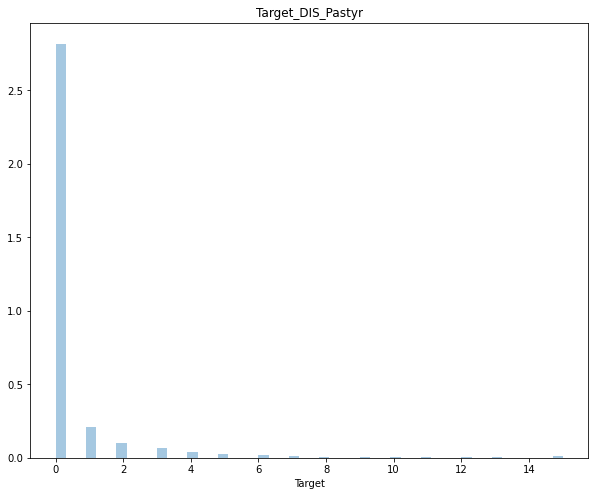

In [38]:
plt.figure(figsize = (10, 8))
sns.distplot(fclaims_pastyr['Target'])
plt. title ('Target_DIS_Pastyr')

In [39]:
fclaims_pastyr.groupby(['Target']).size()

Target
0     64269
1      4835
2      2366
3      1453
4       977
5       565
6       373
7       256
8       173
9       148
10      106
11       80
12       73
13       61
14       42
15      261
dtype: int64

In [40]:
fclaims_pastyr2 = pd.DataFrame()
fclaims_pastyr2 = fclaims_pastyr
fclaims_pastyr2.drop(['Year'], axis='columns', inplace=True)

KeyError: "['Year'] not found in axis"

In [41]:
fclaims_pastyr2.shape

(76038, 120)

In [42]:
#Xác định X, Y của phân tích
#y là target (DIH)
#x là các cột còn lại, k tính Year và Target
y = fclaims_pastyr2.Target
X = fclaims_pastyr2.loc[:, fclaims_pastyr2.columns != 'Target']

#Xác định sử dụng model RandomForestClassifier
model = RandomForestClassifier(max_depth=5, random_state = 0)
#Fit in X, y vào model 
model.fit(X, y)

#Xem xét feature_importance
importances = model.feature_importances_
#Xếp thứ tự các feature (các cột) theo mức độ ảnh hưởng quan trọng lên target
indices = np.argsort(importances)[::-1]

# Tổng hợp feature_importance
for f in range(X.shape[1]):
    print("%d. feature %d %s (%f)" % (f + 1, indices[f], fclaims_pastyr2.columns[indices[f]], importances[indices[f]]))

1. feature 117 missing_sex (0.114098)
2. feature 5 Provider_Total (0.097282)
3. feature 7 Vendor_Distinct (0.070421)
4. feature 11 PayDelay_sum (0.067074)
5. feature 6 Provider_Distinct (0.061909)
6. feature 18 CI_sum (0.060582)
7. feature 114 missing_age (0.058003)
8. feature 14 PCG_Distinct (0.051416)
9. feature 118 ClaimsTruncated (0.044078)
10. feature 10 PlaceSvc_Distinct (0.042439)
11. feature 1 Drug_total (0.041391)
12. feature 113 80.000 (0.037330)
13. feature 9 Specialty_Distinct (0.027821)
14. feature 15 ProG_Distinct (0.024195)
15. feature 16 DSFS_max (0.019674)
16. feature 2 DSFS_drugcount (0.019267)
17. feature 115 Sex_male (0.014638)
18. feature 3 Lab_total (0.014002)
19. feature 12 PayDelay_max (0.012760)
20. feature 116 Sex_female (0.010205)
21. feature 4 DSFS_labcount (0.009007)
22. feature 13 PayDelay_min (0.008850)
23. feature 109 45.000 (0.006831)
24. feature 106 15.000 (0.004867)
25. feature 110 55.000 (0.004192)
26. feature 0 MemberID (0.002461)
27. feature 78 pg1

In [ ]:
# Xét trong top 10:
# missing_sex và missing_age có ảnh hưởng đến xác định số ngày. Thiếu vắng các thông tin quan trọng (khách hoặc chủ quan) có thể liên quan việc bệnh nhân cần được theo dõi kĩ hơn
# Provider_total: số lần claim trong năm, thể hiện việc số lần phải khám chữa bệnh, tình trạng sức khỏe kém
# Vendor_distinct: số lượng vendor service trong năm
# 

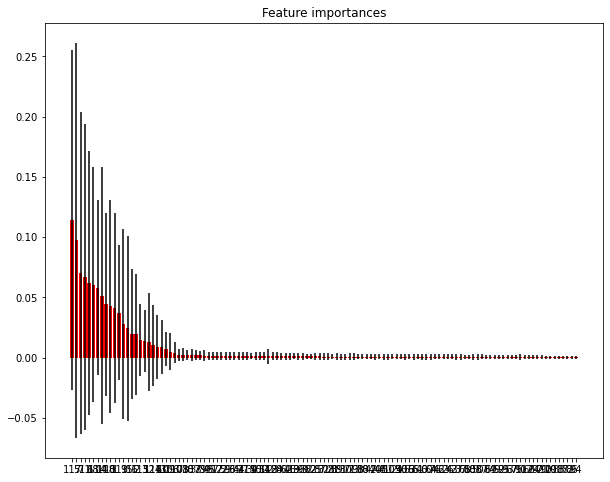

In [43]:
#tính standard deviation (y-error)
std = np.std([x.feature_importances_ for x in model.estimators_],axis = 0)

# Vẽ chart bar để visualize ferature_importance
plt.figure(figsize = (10, 8))
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices])
plt.xticks(range(X.shape[1]),indices)
plt.show()

In [86]:
data = pd.DataFrame()
data = fclaims_pastyr
display(data.describe().transpose())

,count,mean,std,min,25%,50%,75%,max
MemberID,76038.000,49947611.565,28901449.395,210.000,24837194.750,49907210.000,75101120.750,99998627.000
Drug_total,76038.000,10.118,15.353,0.000,0.000,3.000,14.000,84.000
DSFS_drugcount,76038.000,3.704,4.090,0.000,0.000,2.000,7.000,12.000
Lab_total,76038.000,6.149,7.233,0.000,0.000,4.000,10.000,89.000
DSFS_labcount,76038.000,1.580,1.814,0.000,0.000,1.000,2.000,12.000
Provider_Total,76038.000,11.320,10.480,0.000,3.000,8.000,16.000,43.000
Provider_Distinct,76038.000,4.404,3.341,0.000,2.000,3.000,6.000,27.000
Vendor_Distinct,76038.000,3.706,2.616,0.000,2.000,3.000,5.000,19.000
PCP_Distinct,76038.000,1.022,0.151,0.000,1.000,1.000,1.000,3.000
Specialty_Distinct,76038.000,3.183,1.770,0.000,2.000,3.000,4.000,10.000


In [98]:
data2 = pd.DataFrame()
data2 = fclaims_curryr
display(data2.describe().transpose())

,count,mean,std,min,25%,50%,75%,max
Drug_total,71435.000,10.719,16.018,0.000,0.000,3.000,15.000,84.000
DSFS_drugcount,71435.000,3.864,4.210,0.000,0.000,2.000,8.000,12.000
Lab_total,71435.000,6.650,7.876,0.000,0.000,5.000,10.000,94.000
DSFS_labcount,71435.000,1.714,1.975,0.000,0.000,1.000,2.000,12.000
Provider_Total,71435.000,12.512,11.763,0.000,4.000,8.000,17.000,43.000
Provider_Distinct,71435.000,4.666,3.638,0.000,2.000,4.000,6.000,30.000
Vendor_Distinct,71435.000,3.912,2.795,0.000,2.000,3.000,5.000,21.000
PCP_Distinct,71435.000,1.033,0.182,0.000,1.000,1.000,1.000,4.000
Specialty_Distinct,71435.000,3.293,1.825,0.000,2.000,3.000,5.000,10.000
PlaceSvc_Distinct,71435.000,2.216,1.061,0.000,1.000,2.000,3.000,8.000
